In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from matplotlib.pyplot import figure
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from category_encoders import TargetEncoder

In [2]:
DATA_PATH = 'flight-delays-spring-2018/'

In [3]:
train = pd.read_csv(DATA_PATH + "flight_delays_train.csv")
test = pd.read_csv(DATA_PATH + "flight_delays_test.csv")

In [4]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [5]:
train['DayOfWeek'].unique()

array(['c-7', 'c-3', 'c-5', 'c-6', 'c-4', 'c-2', 'c-1'], dtype=object)

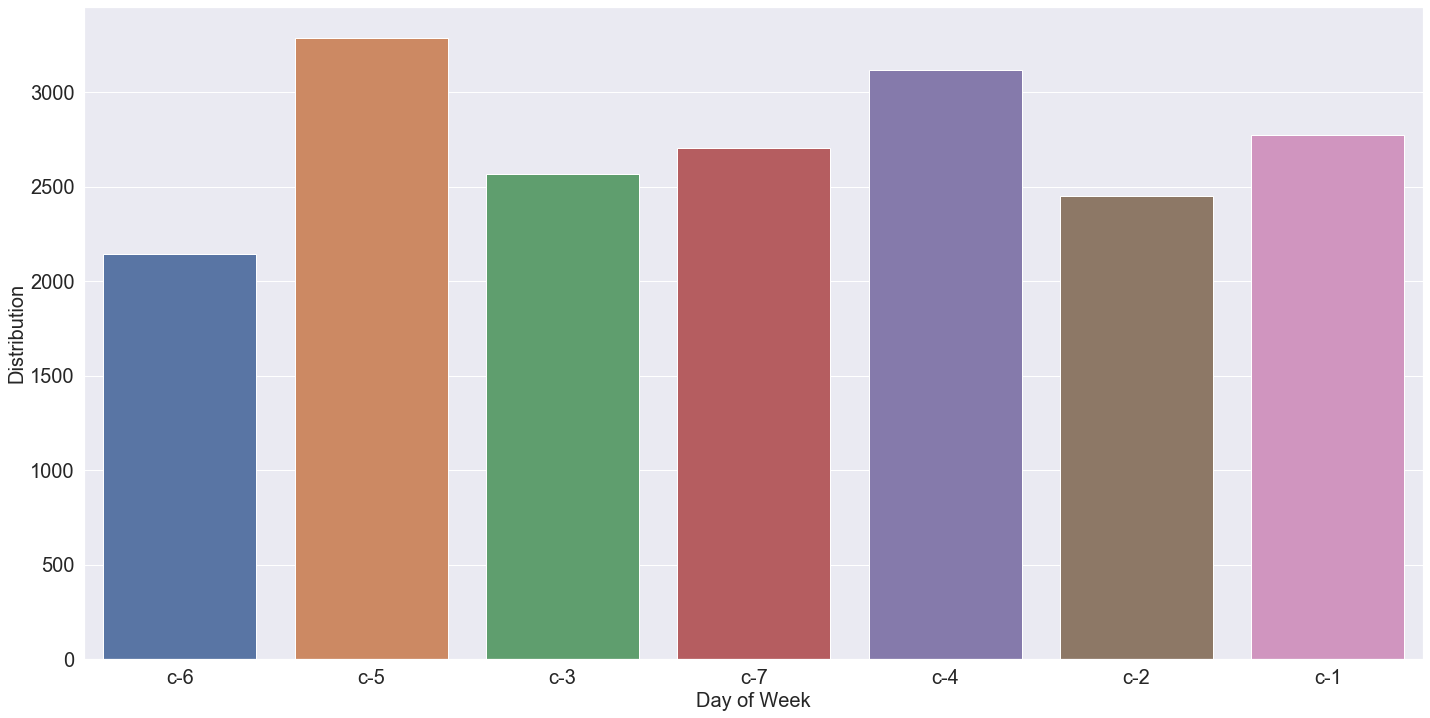

In [11]:
delayed_flights = train[train['dep_delayed_15min'] == 'Y']

sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.countplot(delayed_flights['DayOfWeek'])
plt.xlabel('Day of Week', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

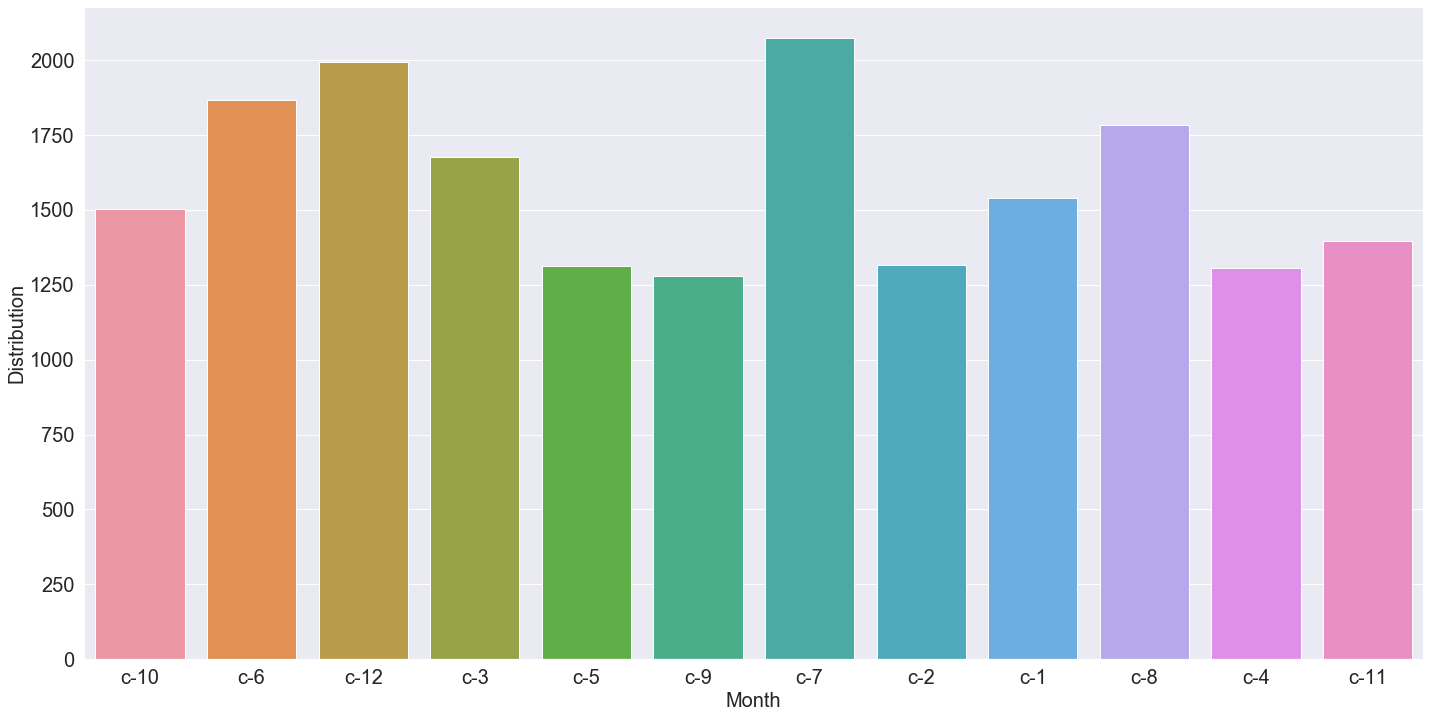

In [12]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.countplot(delayed_flights['Month'])
plt.xlabel('Month', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

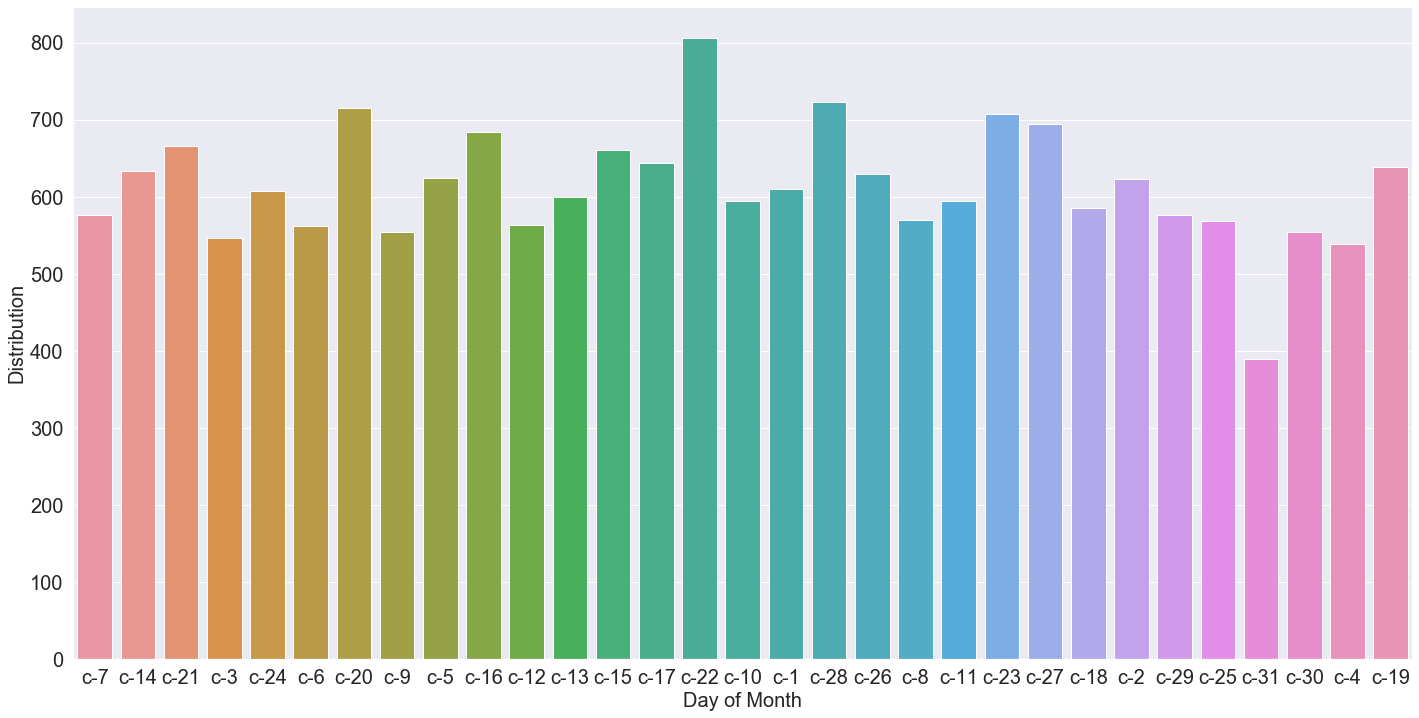

In [13]:
sns.set(rc={"figure.figsize": (24, 12)})
ax = sns.countplot(delayed_flights['DayofMonth'])
plt.xlabel('Day of Month', fontsize=20);
plt.ylabel('Distribution', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [22]:
agg_data = train.pivot_table(index=['Month', 'DayofMonth', 'DayOfWeek'],
                  columns='dep_delayed_15min', aggfunc='size', fill_value=0).reset_index()

In [24]:
agg_data['ratio'] = agg_data.apply(lambda x: float(x['Y']) / (x['N'] + x['Y']), axis = 1)

In [28]:
agg_data.sort_values(by=['ratio'], ascending=False).head(20)

dep_delayed_15min,Month,DayofMonth,DayOfWeek,N,Y,ratio
611,c-8,c-10,c-4,65,75,0.535714
213,c-12,c-22,c-5,75,77,0.506579
22,c-1,c-2,c-1,66,60,0.476190
101,c-10,c-27,c-5,76,66,0.464789
215,c-12,c-23,c-6,71,56,0.440945
198,c-12,c-16,c-5,75,59,0.440299
522,c-6,c-26,c-1,69,53,0.434426
197,c-12,c-15,c-5,95,67,0.413580
265,c-2,c-18,c-6,74,51,0.408000
573,c-7,c-21,c-5,86,57,0.398601


In [29]:
months = train['Month'].unique()

In [45]:
count_per_month = pd.DataFrame(train[['Month', 'dep_delayed_15min']].value_counts().reset_index(name='num_of_flights'))

In [46]:
count_per_month

,Month,dep_delayed_15min,num_of_flights
0,c-5,N,7230
1,c-4,N,7102
2,c-8,N,7047
3,c-3,N,6919
4,c-10,N,6904
5,c-9,N,6884
6,c-11,N,6781
7,c-7,N,6633
8,c-6,N,6547
9,c-1,N,6536


In [52]:
total_flights_per_month = pd.DataFrame(count_per_month.groupby(['Month'])['num_of_flights'].sum().reset_index(name='total_num_of_flights'))

In [55]:
total_flights_per_month

,Month,total_num_of_flights
0,c-1,8075
1,c-10,8405
2,c-11,8178
3,c-12,8265
4,c-2,7418
5,c-3,8595
6,c-4,8408
7,c-5,8543
8,c-6,8414
9,c-7,8706


In [64]:
month_stat = pd.merge(total_flights_per_month, count_per_month[count_per_month.dep_delayed_15min == 'Y'], on='Month')
month_stat.drop(columns=['dep_delayed_15min'], inplace=True)
month_stat['ratio'] = month_stat.apply(lambda x: float(x['num_of_flights']) / x['total_num_of_flights'], axis = 1)

In [65]:
month_stat

,Month,total_num_of_flights,num_of_flights,ratio
0,c-1,8075,1539,0.190588
1,c-10,8405,1501,0.178584
2,c-11,8178,1397,0.170824
3,c-12,8265,1994,0.241258
4,c-2,7418,1316,0.177406
5,c-3,8595,1676,0.194997
6,c-4,8408,1306,0.155328
7,c-5,8543,1313,0.153693
8,c-6,8414,1867,0.221892
9,c-7,8706,2073,0.238112


In [67]:
sum(month_stat['total_num_of_flights'].values)

100000

In [68]:
sum(month_stat['num_of_flights'].values)

19044

In [69]:
sum(month_stat['num_of_flights'].values) / sum(month_stat['total_num_of_flights'].values)

0.19044

In [419]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,hour,minute,night,morning,evening,first_half_month,before_weekends
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,19,34,0,0,0,0,0
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,15,48,0,0,0,0,0
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,14,22,0,0,0,1,1
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,10,15,0,1,0,0,0
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,18,28,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N,16,18,0,0,0,1,0
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N,8,4,0,1,0,0,0
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N,19,1,0,0,0,0,0
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N,15,15,0,0,0,0,1


In [23]:
train['flight'] = train['Origin'] + '-' + train['Dest']
test['flight'] = test['Origin'] + '-' + test['Dest']

In [194]:
def get_train_splitted(tr):
    X_train = tr.drop(columns = ['dep_delayed_15min'])
    y_train = tr["dep_delayed_15min"].map({"Y": 1, "N": 0}).values
    X_train_part, X_valid, y_train_part, y_valid = train_test_split(
        X_train, y_train, test_size=0.3, random_state=17
    )
    return X_train_part, X_valid, y_train_part, y_valid

In [195]:
def get_score(model, tr):
    X_train_part, X_valid, y_train_part, y_valid = get_train_splitted(tr)
    model.fit(X_train_part, y_train_part)
    model_valid_pred = model.predict_proba(X_valid)[:, 1]

    return roc_auc_score(y_valid, model_valid_pred)

# Logistic Regression

## Without any preprocessing

In [261]:
lg = LogisticRegression()
X_train_part, X_valid, y_train_part, y_valid = get_train_splitted(train[["Distance", "DepTime", 'dep_delayed_15min']])

In [262]:
%%time

lg.fit(X_train_part, y_train_part)
lg_pred = lg.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, lg_pred)

Wall time: 157 ms


0.6795697123357751

In [264]:
%%time
cv_score = cross_val_score(LogisticRegression(), train[["Distance", 'DepTime']], 
                           train['dep_delayed_15min'], cv=5, scoring='roc_auc')
np.mean(cv_score)

Wall time: 2.46 s


0.682202981765888

 Logistic regressing with 2 features without any tuning - 0.679

In [5]:
train['hour'] = train['DepTime'].apply(lambda x: x // 100)
train['hour'] = train['hour'].apply(lambda x: x if x < 24 else x // 24)
train['minute'] = train['DepTime'].apply(lambda x: x % 100)


test['hour'] = test['DepTime'].apply(lambda x: x // 100)
test['hour'] = test['hour'].apply(lambda x: x if x < 24 else x // 24)
test['minute'] = test['DepTime'].apply(lambda x: x % 100)

train['night'] = train['hour'].apply(lambda x: int(x >= 24 or x < 4))
train['morning'] = train['hour'].apply(lambda x: int(x >= 4 and x <= 10))
train['evening'] = train['hour'].apply(lambda x: int(x >= 20 and x < 24))

test['night'] = test['hour'].apply(lambda x: int(x >= 24 or x < 4))
test['morning'] = test['hour'].apply(lambda x: int(x >= 4 and x <= 10))
test['evening'] = test['hour'].apply(lambda x: int(x >= 20 and x < 24))

# Half of the month
train['first_half_month'] = train['DayofMonth'].apply(lambda x: int(int(x.split('-')[1]) < 15))

test['first_half_month'] = test['DayofMonth'].apply(lambda x: int(int(x.split('-')[1]) < 15))

#Before weekends
train['before_weekends'] = train['DayOfWeek'].apply(lambda x: int(x in ['c-4', 'c-5']))

test['before_weekends'] = test['DayOfWeek'].apply(lambda x: int(x in ['c-4', 'c-5']))

In [430]:
train['s_hour'] = np.sin(2*np.pi*train['hour']/24)
train['c_hour'] = np.cos(2*np.pi*train['hour']/24)

In [476]:
train['carr_origin'] = train['UniqueCarrier'] + '_' + train['Origin']
train['carr_dest'] = train['UniqueCarrier'] + '_' + train['Dest']

In [437]:
lg = LogisticRegression()
X_train_part, X_valid, y_train_part, y_valid = get_train_splitted(train[["Distance",
                                                                         "DepTime",
                                                                         'hour', 
                                                                         'minute',
                                                                         's_hour', 'c_hour',
                                                                        # 'night',
                                                                        # 'morning',
                                                                        # 'evening',
                                                                        # 'first_half_month', 
                                                                        # 'before_weekends',
                                                                         'dep_delayed_15min']])

In [438]:
%%time

lg.fit(X_train_part, y_train_part)
lg_pred = lg.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, lg_pred)

Wall time: 533 ms


0.679400683059044

Use distance, hour, night - 0.6884925895547058

distance, hour, night, evening, first half - 0.6901646352554289

In [427]:
%%time
cv_score = cross_val_score(LogisticRegression(), train[["Distance", 'hour',  'night', 'before_weekends']], 
                           train['dep_delayed_15min'], cv=5, scoring='roc_auc')
np.mean(cv_score)

Wall time: 4.13 s


0.6936334296993584

In [64]:
def get_ohe_repr(train_data, val_data, column_name):
    label_binarizer = LabelBinarizer()
    train_tr = pd.DataFrame(label_binarizer.fit_transform(train_data[column_name]),
                            columns=[f"{column_name}_{x}" for x in label_binarizer.classes_])
    val_tr = pd.DataFrame(label_binarizer.transform(val_data[column_name]),
                          columns=[f"{column_name}_{x}" for x in label_binarizer.classes_])
    return train_tr, val_tr

In [65]:
def cross_val_score_with_ohe(train_dataset, ohe_columns,
                             non_cat_features = ["Distance", 'hour',  'night', 'before_weekends'],
                             model=LogisticRegression()):

    kf = KFold(n_splits=5)
    X = train_dataset[[*non_cat_features, *ohe_columns]]
    y = train_dataset['dep_delayed_15min'].map({"Y": 1, "N": 0})
    scores = []
    train_ohe_datasets = []
    test_ohe_datasets = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        for ohe in ohe_columns:
            train_ohe, test_ohe = get_ohe_repr(X_train, X_test, ohe)
            train_ohe = train_ohe.set_index(X_train.index)
            test_ohe = test_ohe.set_index(X_test.index)
            train_ohe_datasets.append(train_ohe)
            test_ohe_datasets.append(test_ohe)
            
        
    
        X_train = pd.concat([X_train, *train_ohe_datasets],axis=1)
        X_train = X_train.drop(columns=ohe_columns)
       
    
        X_test = pd.concat([X_test, *test_ohe_datasets],axis=1)
        X_test = X_test.drop(columns=ohe_columns)
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
       
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        train_ohe_datasets = []
        test_ohe_datasets = []
    return scores  
    
    

In [479]:
%%time

cv_score_month = cross_val_score_with_ohe(train, [ 'Month', 'Origin', 'Dest'])
np.mean(cv_score_month)

Wall time: 43.2 s


0.7070355345561451

In [67]:
%%time

cv_score_lg = cross_val_score_with_ohe(train, ['Month', 'Origin', 'Dest', 'UniqueCarrier','h-DoM', 'h-carrier',
                                                   'DoM-carrier',  'Dest-h', 'd-hour-carrier' ])
np.mean(cv_score_lg)

MemoryError: Unable to allocate 4.29 GiB for an array with shape (80000, 14410) and data type int32

In [480]:
%%time

xgb_model = XGBClassifier(seed=17)

cv_score_month = cross_val_score_with_ohe(train, 
                                          [ 'Month', 'Origin', 'Dest',  'UniqueCarrier', 'DayOfWeek',
                                          'DayofMonth'],
                                           non_cat_features=["Distance", 'hour',  'night', 'before_weekends',
                                                             'first_half_month', 'evening',
                                                             'DepTime'],
                                          model=xgb_model)
np.mean(cv_score_month)

[17:34:14] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:39:07] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:43:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:47:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

0.7426032398065219

In [482]:
param_grid = [(a, b) for a in max_leaves for b in max_depth ]

In [487]:
for v in itertools.product(max_leaves, max_depth):
    print(v)

([7, 15, 31, 63], 3)
([7, 15, 31, 63], 4)
([7, 15, 31, 63], 5)
([7, 15, 31, 63], 6)
([7, 15, 31, 63], -1)


In [491]:
# max_leaves = [7, ] 
learning_rate = np.logspace(-3, 0, 10)
scores = []
for lr in learning_rate:
    xgb_model = XGBClassifier(seed=17, max_depth=6, learning_rate=lr)
    cv_score_month = cross_val_score_with_ohe(train, 
                                          [ 'Month', 'Origin', 'Dest',  'UniqueCarrier', 'DayOfWeek',
                                          'DayofMonth'],
                                           non_cat_features=["Distance", 'hour',  'night', 'before_weekends',
                                                             'first_half_month', 'evening',
                                                             'DepTime'],
                                          model=xgb_model)
    score = np.mean(cv_score_month)
    print(f"lr: {lr} score: {score}")
    scores.append([lr, score])
scores    

[14:20:52] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:14] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:25] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:44] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

[14:57:01] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:58:16] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
lr: 0.046415888336127774 score: 0.7308541565791082
[14:59:29] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:00:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: S

[[0.001, 0.7041452453100712],
 [0.0021544346900318843, 0.7063106927358358],
 [0.004641588833612777, 0.709049721714101],
 [0.01, 0.7128856809774519],
 [0.021544346900318832, 0.7190490490797649],
 [0.046415888336127774, 0.7308541565791082],
 [0.1, 0.7398266663317467],
 [0.21544346900318823, 0.7449005337570094],
 [0.46415888336127775, 0.7411242730626366],
 [1.0, 0.7256371664503052]]

In [493]:
xgb_model = XGBClassifier(seed=17, max_depth=6, learning_rate=0.215)
cv_score_month = cross_val_score_with_ohe(train, 
                                          [ 'Month', 'Origin', 'Dest',  'UniqueCarrier', 'DayOfWeek',
                                          'DayofMonth'],
                                           non_cat_features=["Distance", 'hour',  'night', 'before_weekends',
                                                             'first_half_month', 'evening',
                                                             'DepTime'],
                                          model=xgb_model)
score = np.mean(cv_score_month)

[19:42:40] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:43:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:45:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:46:14] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

In [494]:
score

0.7449877482495924

# XGBoost and Linear Regression combinations using OHE only

In [509]:
def get_predictions(X, y, train_index, test_index, ohe_columns, 
                    non_cat_features = ["Distance", 'hour',  'night', 'before_weekends'],
                    model=LogisticRegression()):
    X_train, X_test = X.iloc[train_index][[*non_cat_features, *ohe_columns]], X.iloc[test_index][[*non_cat_features, *ohe_columns]]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    train_ohe_datasets = []
    test_ohe_datasets = []
    for ohe in ohe_columns:
        train_ohe, test_ohe = get_ohe_repr(X_train, X_test, ohe)
        train_ohe = train_ohe.set_index(X_train.index)
        test_ohe = test_ohe.set_index(X_test.index)
        train_ohe_datasets.append(train_ohe)
        test_ohe_datasets.append(test_ohe)
            
        
    
    X_train = pd.concat([X_train, *train_ohe_datasets],axis=1)
    X_train = X_train.drop(columns=ohe_columns)
       
    
    X_test = pd.concat([X_test, *test_ohe_datasets],axis=1)
    X_test = X_test.drop(columns=ohe_columns)
        
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
       
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    return y_pred
    




def cross_val_score_with_ohe_comb(train_dataset, lg_ohe_columns, xgb_ohe_columns, log_regr, xgboost, coef = 0.4,
                                  non_cat_features_lg = ["Distance", 'hour',  'night', 'before_weekends'],
                                  non_cat_features_xgb = ["Distance", 'hour',  'night', 'before_weekends']):

    kf = KFold(n_splits=5)
    X = train_dataset.drop(columns=['dep_delayed_15min'])
    y = train_dataset['dep_delayed_15min'].map({"Y": 1, "N": 0})
    scores = []
    scores_lg = []
    scores_xgb = []
    for train_index, test_index in kf.split(X):
        y_test = y.iloc[test_index]
        y_pred_lg = get_predictions(X, y, train_index, test_index, lg_ohe_columns, non_cat_features_lg, log_regr)
        
        scores_lg.append(roc_auc_score(y_test, y_pred_lg))
        
        y_pred_xgb = get_predictions(X, y, train_index, test_index, xgb_ohe_columns, non_cat_features_xgb, xgboost)
        
        scores_xgb.append(roc_auc_score(y_test, y_pred_xgb))
        
        y_pred_final = coef * y_pred_lg + (1 - coef) * y_pred_xgb
        
        score = roc_auc_score(y_test, y_pred_final)
        scores.append(score)
    return scores, scores_lg, scores_xgb  

In [523]:
%%time
log_regr = LogisticRegression()
xgb_model = XGBClassifier(seed=17, max_depth=6, learning_rate=0.215)

cv_score_combination, cv_lg, cv_xgb = cross_val_score_with_ohe_comb(train, 
                                                                    coef=0.5,
                                                                    lg_ohe_columns=[ 'Month', 'Origin', 'Dest'],
                              log_regr=log_regr, xgboost=xgb_model, 
                              xgb_ohe_columns=['Month', 'Origin', 'Dest',  'UniqueCarrier', 'DayOfWeek','DayofMonth'],
                              non_cat_features_xgb=["Distance", 'hour',  'night', 'before_weekends', 
                                                    'first_half_month', 'evening', 'DepTime'])
print(np.mean(cv_lg))
print(np.mean(cv_xgb))
print(np.mean(cv_score_combination))

[11:55:55] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:23] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:45] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:00:12] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

In [507]:
np.mean(cv_lg)

0.7070355345561451

In [508]:
np.mean(cv_xgb)

0.7449877482495924

In [516]:
def get_prediction_full(train, test, ohe_columns, non_cat_columns, model):
    X_train, X_test = train[[*non_cat_columns, *ohe_columns]], test[[*non_cat_columns, *ohe_columns]]
    y_train = train['dep_delayed_15min'].map({"Y": 1, "N": 0})
    train_ohe_datasets = []
    test_ohe_datasets = []
    for ohe in ohe_columns:
        train_ohe, test_ohe = get_ohe_repr(X_train, X_test, ohe)
        train_ohe = train_ohe.set_index(X_train.index)
        test_ohe = test_ohe.set_index(X_test.index)
        train_ohe_datasets.append(train_ohe)
        test_ohe_datasets.append(test_ohe)
            
        
    
    X_train = pd.concat([X_train, *train_ohe_datasets],axis=1)
    X_train = X_train.drop(columns=ohe_columns)
       
    
    X_test = pd.concat([X_test, *test_ohe_datasets],axis=1)
    X_test = X_test.drop(columns=ohe_columns)
        
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
       
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    return y_pred

In [ ]:
log_regr = LogisticRegression()
xgb_model = XGBClassifier(seed=17, max_depth=6, learning_rate=0.215)

lg_pred = get_prediction_full(train, test, ohe_columns = [ 'Month', 'Origin', 'Dest'], non_cat_columns = )

cross_val_score_with_ohe_comb(train, 
                                                                    coef=0.05,
                                                                    lg_ohe_columns=[ 'Month', 'Origin', 'Dest'],
                              log_regr=log_regr, xgboost=xgb_model, 
                              xgb_ohe_columns=['Month', 'Origin', 'Dest',  'UniqueCarrier', 'DayOfWeek','DayofMonth'],
                              non_cat_features_xgb=["Distance", 'hour',  'night', 'before_weekends', 
                                                    'first_half_month', 'evening', 'DepTime'])


In [520]:
xgb_model = XGBClassifier(seed=17, max_depth=6, learning_rate=0.215)
preds = get_prediction_full(train, test, 
                    ohe_columns = ['Month', 'Origin', 'Dest',  'UniqueCarrier', 'DayOfWeek','DayofMonth'], 
                    non_cat_columns = ["Distance", 'hour',  'night', 'before_weekends', 
                                                    'first_half_month', 'evening', 'DepTime'], model=xgb_model)

[21:15:19] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [522]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv( 'sample_submission.csv.zip', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = preds
    sample_sub.to_csv('xgb_pred.csv')

# Feature hashing

In [6]:
from category_encoders import HashingEncoder

In [7]:
def get_predictions_hash(X, y, train_index, test_index, ohe_columns, 
                    non_cat_features = ["Distance", 'hour',  'night', 'before_weekends'],
                    model=LogisticRegression()):
    X_train, X_test = X.iloc[train_index][[*non_cat_features, *ohe_columns]], X.iloc[test_index][[*non_cat_features, *ohe_columns]]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    hashing_enc = HashingEncoder(cols=ohe_columns, n_components=1000).fit(X_train, y_train)
                    
    X_train_hashing = hashing_enc.transform(X_train.reset_index(drop=True))
    X_test_hashing = hashing_enc.transform(X_test.reset_index(drop=True))
    
        
    scaler = StandardScaler()
    X_train_hashing = scaler.fit_transform(X_train_hashing)
    X_test_hashing = scaler.transform(X_test_hashing)
    
       
    model.fit(X_train_hashing, y_train)
    y_pred = model.predict_proba(X_test_hashing)[:, 1]
    return y_pred

In [8]:
def cross_val_score_with_hashing(train_dataset, ohe_columns, 
                                 non_cat_features = ["Distance", 'hour',  'night', 'before_weekends'], 
                                 model = LogisticRegression()):

    kf = KFold(n_splits=5)
    X = train_dataset.drop(columns=['dep_delayed_15min'])
    y = train_dataset['dep_delayed_15min'].map({"Y": 1, "N": 0})
    scores = []
    for train_index, test_index in kf.split(X):
        y_test = y.iloc[test_index]
        y_pred = get_predictions_hash(X, y, train_index, test_index, ohe_columns, non_cat_features, model)
        
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
    return scores

In [9]:
%%time

cv_score_lg = cross_val_score_with_hashing(train, [ 'Month', 'Origin', 'Dest', 'UniqueCarrier'])
np.mean(cv_score_lg)

Wall time: 9min 46s


0.7144784769811987

In [69]:
%%time

cv_score_lg = cross_val_score_with_hashing(train, ['Month', 'Origin', 'Dest', 'UniqueCarrier','h-DoM', 'h-carrier',
                                                   'DoM-carrier' ])
np.mean(cv_score_lg)


Wall time: 10min 9s


0.7132788456419014

In [12]:
%%time

xgb_model = XGBClassifier(seed=17, max_depth=6, learning_rate=0.215)

cv_score_xgb = cross_val_score_with_hashing(train,
                                            ['Month', 'Origin', 'Dest',  'UniqueCarrier', 'DayOfWeek','DayofMonth'],
                                            non_cat_features= ["Distance", 'hour',  'night', 'before_weekends'],
                                            model=xgb_model)
np.mean(cv_score_xgb)

[16:28:19] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:32:09] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:35:55] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:39:59] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

0.7352371955763075

In [52]:
def cross_val_score_with_hashing_comb(train_dataset, ohe_columns_1, ohe_columns_2, model_1, model_2, coef,
                                      non_cat_features_1 = ["Distance", 'hour',  'night', 'before_weekends'], 
                                      non_cat_features_2 = ["Distance", 'hour',  'night', 'before_weekends']):

    kf = KFold(n_splits=5)
    X = train_dataset.drop(columns=['dep_delayed_15min'])
    y = train_dataset['dep_delayed_15min'].map({"Y": 1, "N": 0})
    scores = []
    scores_1 = []
    scores_2 = []
    print(coef)
    for train_index, test_index in kf.split(X):
        y_test = y.iloc[test_index]
        y_pred_1 = get_predictions_hash(X, y, train_index, test_index, ohe_columns_1, non_cat_features_1, model_1)
        
        scores_1.append(roc_auc_score(y_test, y_pred_1))
        
        y_pred_2 = get_predictions_hash(X, y, train_index, test_index, ohe_columns_2, non_cat_features_2, model_2)
        
        scores_2.append(roc_auc_score(y_test, y_pred_2))
        
        y_pred = coef * y_pred_1 + (1 - coef) * y_pred_2
        
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
    return scores, scores_1, scores_2

In [58]:
%%time
lg = LogisticRegression()
xgb_model = XGBClassifier(seed=17, max_depth=6, learning_rate=0.215, n_estimators=500)

scores, scores_lg, scores_xgb = cross_val_score_with_hashing_comb(
    train, 
    ohe_columns_1 = ['Month', 'Origin', 'Dest', 'UniqueCarrier'], 
    ohe_columns_2 = ['Month', 'Origin', 'Dest',  'UniqueCarrier', 'DayOfWeek','DayofMonth'],
    model_1 = lg, model_2 = xgb_model, coef = 0.25,
    non_cat_features_2 = ["Distance", 'hour',  'night', 'before_weekends', 
                          'first_half_month', 'evening', 'DepTime']
    
)

print(np.mean(scores_lg))
print(np.mean(scores_xgb))
print(np.mean(scores))

0.2
[11:25:46] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:36:36] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:47:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:59:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluatio

 0.35 
 0.7144784769811987
0.7423956527728055
0.7441798181792334

0.25
0.7144784769811987
0.7423956527728055
0.7447270604248639

In [59]:
train['summer'] = (train['Month'].isin(['c-6', 'c-7', 'c-8'])).astype(np.int32)
train['autumn'] = (train['Month'].isin(['c-9', 'c-10', 'c-11'])).astype(np.int32)
train['winter'] = (train['Month'].isin(['c-12', 'c-1', 'c-2'])).astype(np.int32)
train['spring'] = (train['Month'].isin(['c-3', 'c-4', 'c-5'])).astype(np.int32)


train['daytime'] = pd.cut(train['hour'], bins=[0, 6, 12, 18, 23], labels = [0,1,2,3], include_lowest=True).astype('object')
train['DistanceBin'] = pd.cut(train['Distance'], bins=[0,100,300,800,1500,3000], labels = [0,1,2,3,4], include_lowest = True)
train['DistanceBin'].fillna(0, inplace = True)
train['DistanceBin'] = train['DistanceBin'].astype('object')


train['h-DoM'] = train['hour'].astype('str') + '----' + train['DayofMonth']
train['h-carrier'] = train['hour'].astype('str') + '----' + train['UniqueCarrier']
train['DoM-carrier'] = train['DayofMonth'] + '----' +  train['UniqueCarrier']

train['Dest-DoM'] = train['Dest'] + '--' + train['DayofMonth']
train['Dest-h'] = train['Dest'] + '--' + train['hour'].astype('str')
train['Dest-carrier'] = train['Dest'] + '--' + train['UniqueCarrier']

train['d-hour-carrier'] = train['Dest'] + train['hour'].astype('str') + train['UniqueCarrier']
train['m-hour-carrier'] = train['DayofMonth'] + train['hour'].astype('str') + train['UniqueCarrier']
train['d-hour-dom'] = train['Dest'] + train['hour'].astype('str') + train['DayofMonth'] 

In [60]:
%%time

cv_score_lg = cross_val_score_with_hashing(train, ['Month', 'Origin', 'Dest', 'UniqueCarrier','h-DoM', 'h-carrier',
                                                   'DoM-carrier', 'Dest-DoM', 'Dest-h',
                                                   'Dest-carrier', 'd-hour-carrier', 'm-hour-carrier', 'd-hour-dom'
                                                  ])
np.mean(cv_score_lg)

Wall time: 10min 12s


0.7075226533866947

# Target encoding

In [16]:
from category_encoders import TargetEncoder

In [17]:
def get_predictions_target(X, y, train_index, test_index, ohe_columns, 
                    non_cat_features = ["Distance", 'hour',  'night', 'before_weekends'],
                    model=LogisticRegression()):
    X_train, X_test = X.iloc[train_index][[*non_cat_features, *ohe_columns]], X.iloc[test_index][[*non_cat_features, *ohe_columns]]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    targ_enc  = TargetEncoder(cols=ohe_columns, smoothing=8, min_samples_leaf=5).fit(X_train, y_train)
                    
    X_train_hashing = targ_enc.transform(X_train.reset_index(drop=True))
    X_test_hashing = targ_enc.transform(X_test.reset_index(drop=True))
    
        
    scaler = StandardScaler()
    X_train_hashing = scaler.fit_transform(X_train_hashing)
    X_test_hashing = scaler.transform(X_test_hashing)
    
       
    model.fit(X_train_hashing, y_train)
    y_pred = model.predict_proba(X_test_hashing)[:, 1]
    return y_pred

In [18]:
def cross_val_score_with_target(train_dataset, ohe_columns, 
                                 non_cat_features = ["Distance", 'hour',  'night', 'before_weekends'], 
                                 model = LogisticRegression()):

    kf = KFold(n_splits=5)
    X = train_dataset.drop(columns=['dep_delayed_15min'])
    y = train_dataset['dep_delayed_15min'].map({"Y": 1, "N": 0})
    scores = []
    for train_index, test_index in kf.split(X):
        y_test = y.iloc[test_index]
        y_pred = get_predictions_target(X, y, train_index, test_index, ohe_columns, non_cat_features, model)
        
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
    return scores

In [29]:
%%time

cv_score_lg = cross_val_score_with_target(train, 
                                          non_cat_features=["Distance", 'hour',  'night', 'before_weekends', 
                          'first_half_month', 'evening', 'DepTime'],
                                          ohe_columns = ['Month', 'Origin', 'Dest', 'UniqueCarrier', 'DayOfWeek','DayofMonth'])
np.mean(cv_score_lg)

Wall time: 5.66 s


0.7112463111584454

In [32]:
%%time

xgb_model = XGBClassifier(seed=17, max_depth=6, learning_rate=0.215, n_estimators=500)

cv_score_xgb = cross_val_score_with_target(train,
                                            ohe_columns = ['Month', 'Origin', 'Dest', 'UniqueCarrier', 'DayOfWeek','DayofMonth'],
                                             non_cat_features=["Distance", 'hour',  'night', 'before_weekends', 
                          'first_half_month', 'evening', 'DepTime'],
                                            model=xgb_model)
np.mean(cv_score_xgb)

[18:29:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:10] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:34] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:54] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

0.7392948138500158

# Weight of evidence

In [37]:
from category_encoders import WOEEncoder

In [38]:
def get_predictions_woe(X, y, train_index, test_index, ohe_columns, 
                    non_cat_features = ["Distance", 'hour',  'night', 'before_weekends'],
                    model=LogisticRegression()):
    X_train, X_test = X.iloc[train_index][[*non_cat_features, *ohe_columns]], X.iloc[test_index][[*non_cat_features, *ohe_columns]]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    woe_enc = WOEEncoder(cols=ohe_columns, random_state=17).fit(X_train, y_train)
                    
    X_train_hashing = woe_enc.transform(X_train.reset_index(drop=True))
    X_test_hashing = woe_enc.transform(X_test.reset_index(drop=True))
    
        
    scaler = StandardScaler()
    X_train_hashing = scaler.fit_transform(X_train_hashing)
    X_test_hashing = scaler.transform(X_test_hashing)
    
       
    model.fit(X_train_hashing, y_train)
    y_pred = model.predict_proba(X_test_hashing)[:, 1]
    return y_pred

In [39]:
def cross_val_score_with_any_enc(train_dataset, ohe_columns, 
                                pred_func,
                                 non_cat_features = ["Distance", 'hour',  'night', 'before_weekends'],
                                 model = LogisticRegression()):

    kf = KFold(n_splits=5)
    X = train_dataset.drop(columns=['dep_delayed_15min'])
    y = train_dataset['dep_delayed_15min'].map({"Y": 1, "N": 0})
    scores = []
    for train_index, test_index in kf.split(X):
        y_test = y.iloc[test_index]
        y_pred = pred_func(X, y, train_index, test_index, ohe_columns, non_cat_features, model)
        
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
    return scores

In [43]:
%%time

cv_score_lg = cross_val_score_with_any_enc(train, 
                                          pred_func=get_predictions_woe,
                                          non_cat_features=["Distance", 'hour',  'night', 'before_weekends', 
                          'first_half_month', 'evening', 'DepTime'],
                                          ohe_columns = ['Month', 'Origin', 'Dest', 'UniqueCarrier', 'DayOfWeek','DayofMonth'])
np.mean(cv_score_lg)

Wall time: 6.03 s


0.7111922787028627

In [44]:
%%time

xgb_model = XGBClassifier(seed=17, max_depth=6, learning_rate=0.215, n_estimators=500)

cv_score_xgb = cross_val_score_with_any_enc(train,pred_func=get_predictions_woe,
                                            ohe_columns = ['Month', 'Origin', 'Dest', 'UniqueCarrier',
                                                           'DayOfWeek','DayofMonth'],
                                            non_cat_features=["Distance", 'hour',  'night', 'before_weekends', 
                                                               'first_half_month', 'evening', 'DepTime'],
                                            model=xgb_model)
np.mean(cv_score_xgb)

[18:35:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:25] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:44] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

0.7397628568457904

# Binary encoding

In [45]:
from category_encoders import BinaryEncoder

In [46]:
def get_predictions_binary_enc(X, y, train_index, test_index, ohe_columns, 
                    non_cat_features = ["Distance", 'hour',  'night', 'before_weekends'],
                    model=LogisticRegression()):
    X_train, X_test = X.iloc[train_index][[*non_cat_features, *ohe_columns]], X.iloc[test_index][[*non_cat_features, *ohe_columns]]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    binary_enc = BinaryEncoder(cols=ohe_columns).fit(X_train, y_train)
                    
    X_train_hashing = binary_enc.transform(X_train.reset_index(drop=True))
    X_test_hashing = binary_enc.transform(X_test.reset_index(drop=True))
    
        
    scaler = StandardScaler()
    X_train_hashing = scaler.fit_transform(X_train_hashing)
    X_test_hashing = scaler.transform(X_test_hashing)
    
       
    model.fit(X_train_hashing, y_train)
    y_pred = model.predict_proba(X_test_hashing)[:, 1]
    return y_pred

In [50]:
%%time

cv_score_lg = cross_val_score_with_any_enc(train, 
                                          pred_func=get_predictions_binary_enc,
                                          non_cat_features=["Distance", 'hour',  'night', 'before_weekends', 
                          'first_half_month', 'evening', 'DepTime'],
                                          ohe_columns = ['Month', 'Origin', 'Dest', 'UniqueCarrier', 'DayOfWeek','DayofMonth'])
np.mean(cv_score_lg)

Wall time: 9.2 s


0.7025043885012281

In [51]:
%%time

xgb_model = XGBClassifier(seed=17, max_depth=6, learning_rate=0.215, n_estimators=500)

cv_score_xgb = cross_val_score_with_any_enc(train,pred_func=get_predictions_binary_enc,
                                            ohe_columns = ['Month', 'Origin', 'Dest', 'UniqueCarrier',
                                                           'DayOfWeek','DayofMonth'],
                                            non_cat_features=["Distance", 'hour',  'night', 'before_weekends', 
                                                               'first_half_month', 'evening', 'DepTime'],
                                            model=xgb_model)
np.mean(cv_score_xgb)

[18:38:16] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:48] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:20] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

0.7344605558010876

In [529]:
X_train = train.drop(columns = ['dep_delayed_15min'])
y_train = train["dep_delayed_15min"].map({"Y": 1, "N": 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split( X_train, y_train, test_size=0.3, random_state=17)

In [542]:
%%time
hashing_enc = HashingEncoder(cols=['Month', 'Origin', 'Dest'], n_components=1000).fit(X_train_part, y_train_part)
X_train_hashing = hashing_enc.transform(X_train_part.reset_index(drop=True))
X_valid_hashing = hashing_enc.transform(X_valid.reset_index(drop=True))

Wall time: 1min 58s


In [543]:
X_train_hashing = X_train_hashing.drop(columns=[ 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier'])
X_valid_hashing = X_valid_hashing.drop(columns=[ 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier'])

In [545]:
scaler = StandardScaler()
X_train_hashing = scaler.fit_transform(X_train_hashing)
X_valid_hashing = scaler.transform(X_valid_hashing)

In [548]:
lg = LogisticRegression()
lg.fit(X_train_hashing, y_train_part)
y_pred = lg.predict_proba(X_valid_hashing)[:, 1]

In [549]:
roc_auc_score(y_valid, y_pred)

0.7076558612671646

In [116]:
lb_month = LabelBinarizer()
month = pd.DataFrame(lb_month.fit_transform(train['Month']), columns=[f"m_{x}" for x in lb_month.classes_])

train_mod = pd.concat([train,month],axis=1)
train_mod = train_mod.drop(columns=['Month'])

get_score(lg, train_mod.drop(columns=['DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']))

0.6853003067835673

In [127]:
lb_dest = LabelBinarizer()
dest = pd.DataFrame(lb_unique.fit_transform(train['Dest']), columns=lb_unique.classes_)

lb_origin = LabelBinarizer()
origin = pd.DataFrame(lb_unique.fit_transform(train['Origin']), columns=lb_unique.classes_)

train_mod = pd.concat([train, 
                       month,
                       dest, 
                       origin
                      ],axis=1)
train_mod = train_mod.drop(columns=['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'])

get_score(LogisticRegression(), train_mod)

0.6892126359938712

In [134]:
%%time
train_mod = train
train_mod['flight'] = train_mod['Origin'] + '-' + train_mod['Dest']

lb_flight = LabelBinarizer()
flight = pd.DataFrame(lb_flight.fit_transform(train_mod['flight']), columns=lb_flight.classes_)


train_mod = pd.concat([train,
                        month,
                       flight,
                        dest, 
                       origin
                      ],axis=1)
train_mod = train_mod.drop(columns=['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'flight'])

get_score(LogisticRegression(), train_mod)

Wall time: 1min 3s


0.6894253479718501

Flight is a very doubtful feature

In [138]:
%%time
lb_day_of_week = LabelBinarizer()
day_of_week = pd.DataFrame(lb_day_of_week.fit_transform(train['DayOfWeek']), 
                           columns=[f"dw_{x}" for x in lb_day_of_week.classes_])

train_mod = pd.concat([train, 
                       day_of_week, dest, 
                       origin,
                       month
                      ],axis=1)
train_mod = train_mod.drop(columns=['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'flight'])

get_score(LogisticRegression(), train_mod)

Wall time: 4.52 s


0.6880076042138357

Day of Week is also a doubtful feature with OHE

In [140]:
lb_day_of_month = LabelBinarizer()
day_of_month = pd.DataFrame(lb_day_of_month.fit_transform(train['DayofMonth']),
                            columns=[f"dm_{x}" for x in lb_day_of_month.classes_])

train_mod = pd.concat([train, 
                       day_of_month, dest, 
                       origin,
                       month
                      ],axis=1)
train_mod = train_mod.drop(columns=['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'flight'])

get_score(LogisticRegression(), train_mod)

0.690344799196128

In [177]:
%%time
train_mod = pd.concat([train, 
                       day_of_month,
                       day_of_week,
                       flight,
                      unique_carrier,
                       dest, 
                       origin,
                       month
                      ],axis=1)
train_mod = train_mod.drop(columns=['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'flight'])

#get_score(LogisticRegression(), train_mod)

Wall time: 14.3 s


In [161]:
train_mod.head()

,DepTime,Distance,dep_delayed_15min,dm_c-1,dm_c-10,dm_c-11,dm_c-12,dm_c-13,dm_c-14,dm_c-15,...,m_c-11,m_c-12,m_c-2,m_c-3,m_c-4,m_c-5,m_c-6,m_c-7,m_c-8,m_c-9
0,1934,732,N,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1548,834,N,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1422,416,N,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1015,872,N,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1828,423,Y,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
%%time
cv_score = cross_val_score(LogisticRegression(), train_mod.drop(columns=['dep_delayed_15min']),
                train_mod['dep_delayed_15min'], cv=5, scoring='roc_auc')

Wall time: 3min 24s


In [184]:
np.mean(cv_score)

0.6984504420966946

In [180]:
cv_score

array([0.69210854, 0.70278836, 0.70553505])

In [181]:
X_train_part = train_mod.drop(columns=['dep_delayed_15min'])
y_train_part = train_mod['dep_delayed_15min']
params = {'C': np.logspace(-3, 1, 10)}
log_regr = LogisticRegression()
grid_search = GridSearchCV(log_regr, params, cv=3, verbose=10, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train_part, y_train_part)

grid_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   42.0s remaining:   24.2s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   42.1s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   45.9s remaining:    5.0s


MemoryError: Unable to allocate 646. MiB for an array with shape (5079, 33334) and data type int32

In [169]:
grid_search.best_score_

0.6964405336551912

In [54]:
count_per_month[count_per_month.dep_delayed_15min == 'Y']

,Month,dep_delayed_15min,num_of_flights
12,c-7,Y,2073
13,c-12,Y,1994
14,c-6,Y,1867
15,c-8,Y,1783
16,c-3,Y,1676
17,c-1,Y,1539
18,c-10,Y,1501
19,c-11,Y,1397
20,c-2,Y,1316
21,c-5,Y,1313


# XGBoost

In [186]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,flight
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,ATL-DFW
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,PIT-MCO
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,RDU-CLE
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,DEN-MEM
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,MDW-OMA


In [187]:
def get_train_splitted(train):
    X_train = train[["Distance", "DepTime"]].values
    y_train = train["dep_delayed_15min"].map({"Y": 1, "N": 0}).values
    X_train_part, X_valid, y_train_part, y_valid = train_test_split(
        X_train, y_train, test_size=0.3, random_state=17
    )
    return X_train_part, X_valid, y_train_part, y_valid

In [188]:
X_test = test[["Distance", "DepTime"]].values

X_train_part, X_valid, y_train_part, y_valid = get_train_splitted(train)

In [189]:
%%time
xgb_model = XGBClassifier(seed=17)

xgb_model.fit(X_train_part, y_train_part)
xgb_valid_pred = xgb_model.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

[23:26:12] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2.14 s


0.7001228548770644

In [8]:
xgb_model.fit(X_train, y_train)
xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]

pd.Series(xgb_test_pred, name="dep_delayed_15min").to_csv(
    "xgb_2feat.csv", index_label="id", header=True
)

[21:19:43] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [6]:
train['Flight'] = train.apply(lambda x: f"{x['Origin']}-{x['Dest']}", axis=1)

In [192]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,flight
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,ATL-DFW
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,PIT-MCO
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,RDU-CLE
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,DEN-MEM
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,MDW-OMA


In [200]:
train_mod.head()

,DepTime,Distance,dep_delayed_15min,ABE,ABI,ABQ,ABY,ACK,ACT,ACV,...,TYS,VCT,VIS,VLD,VPS,WRG,WYS,XNA,YAK,YUM
0,1934,732,N,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1548,834,N,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1422,416,N,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1015,872,N,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1828,423,Y,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [216]:
%%time
# lb_dest = LabelBinarizer()
# dest = pd.DataFrame(lb_unique.fit_transform(train['Dest']), columns=lb_unique.classes_)

# lb_origin = LabelBinarizer()
# origin = pd.DataFrame(lb_unique.fit_transform(train['Origin']), columns=lb_unique.classes_)

train_mod = pd.concat([train, 
                       day_of_month,
                   #    flight,
                       day_of_week,
                        unique_carrier,
                         month,
                         origin, pd.DataFrame(dest, columns=[f"dest_{x}" for x in dest.columns])
                      ],axis=1)
train_mod = train_mod.drop(columns=['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'flight'])

get_score(XGBClassifier(seed=17), train_mod)

[00:14:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 32.3 s


0.7312887104118719

In [214]:
train['summer'] = train['Month'].apply(lambda x: int(x in ['c-6', 'c-7', 'c-8']))
train['is_holiday'] = train['DayOfWeek'].apply(lambda x: int(x in ['c-6', 'c-7']))
train['uniq_carr_origin'] = train.apply(lambda x: x['UniqueCarrier'] + '-' + x['Origin'], axis=1)

In [215]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,flight,summer,is_holiday
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,ATL-DFW,1,1
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,PIT-MCO,0,0
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,RDU-CLE,0,0
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,DEN-MEM,0,1
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,MDW-OMA,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N,SFO-RDD,0,0
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N,EWR-DAB,0,0
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N,DTW-IAH,0,0
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N,DFW-GGG,0,0


In [8]:
# lb_month = LabelBinarizer()
# month = pd.DataFrame(lb_month.fit_transform(train['Month']), columns=[f"m_{x}" for x in lb_month.classes_])

# lb_day_of_month = LabelBinarizer()
# day_of_month = pd.DataFrame(lb_day_of_month.fit_transform(train['DayofMonth']),
#                             columns=[f"dm_{x}" for x in lb_day_of_month.classes_])

# lb_day_of_week = LabelBinarizer()
# day_of_week = pd.DataFrame(lb_day_of_week.fit_transform(train['DayOfWeek']), 
#                            columns=[f"dw_{x}" for x in lb_day_of_week.classes_])

# lb_unique = LabelBinarizer()
# unique_carrier = pd.DataFrame(lb_unique.fit_transform(train['UniqueCarrier']), columns=lb_unique.classes_)

# lb_flight = LabelBinarizer()
# flight = pd.DataFrame(lb_flight.fit_transform(train['Flight']), columns=lb_flight.classes_)

In [9]:
train_modified = pd.concat([train,month, day_of_month, day_of_week, unique_carrier, flight],axis=1)

In [10]:
train_modified = train_modified.drop(columns=['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier',
                                              'Origin', 'Dest', 'Flight'])

In [11]:
del train
del month
del day_of_month
del day_of_week
del unique_carrier
del flight

In [12]:
train_modified

,DepTime,Distance,dep_delayed_15min,m_c-1,m_c-10,m_c-11,m_c-12,m_c-2,m_c-3,m_c-4,...,XNA-IAH,XNA-LAX,XNA-LGA,XNA-ORD,XNA-SLC,YAK-CDV,YAK-JNU,YUM-IPL,YUM-LAX,YUM-PHX
0,1934,732,N,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1548,834,N,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1422,416,N,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1015,872,N,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1828,423,Y,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1618,199,N,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,804,884,N,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99997,1901,1076,N,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99998,1515,140,N,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X_train = train_modified.drop(columns = ['dep_delayed_15min'])
y_train = train_modified["dep_delayed_15min"].map({"Y": 1, "N": 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(
        X_train, y_train, test_size=0.3, random_state=17
)

In [20]:
lg = LogisticRegression(random_state=17)
lg.fit(X_train_part, y_train_part)
lg_valid_pred = lg.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, lg_valid_pred)

0.6835109807916165

In [21]:
%%time
xgb_model = XGBClassifier(seed=17)

xgb_model.fit(X_train_part, y_train_part)
xgb_valid_pred = xgb_model.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

[14:25:26] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 7min 30s


0.7230444782675478

In [16]:
%%time
param_dist = {
    #"min_child_weight" : [1,3,6],
              'max_leaves': [7, 15, 31, 63], 
              'max_depth': [3, 4, 5, 6, -1]}
grid_search = GridSearchCV(xgb_model, param_grid=param_dist, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(X_train_part, y_train_part)

grid_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 65.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 120.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 193.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 226.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 337.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 419.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 546.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 577.2min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 601.1min remaining: 25.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 605.7min finished


[08:17:43] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 10h 11min 30s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, max_leaves=7, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=8, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=17, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=17, subsample=1, tree_method='exact',
              use_label_encoder=True, ...)

In [13]:
space={'learning_rate': hp.choice('learning_rate',np.logspace(-3, 0, 10)) }

In [15]:
space

{'learning_rate': <hyperopt.pyll.base.Apply at 0x2b8b7f11ba8>}

In [15]:
def objective(space):
    clf=XGBClassifier(
                    n_estimators=500, max_depth = 6,
                    min_child_weight=1,
                    learning_rate = float(space['learning_rate']),
                    seed=17)
    
    evaluation = [( X_train_part, y_train_part), ( X_valid, y_valid)]
    
    clf.fit(X_train_part, y_train_part,
            eval_set=evaluation,
            eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

   # pred = clf.predict(X_test)
    xgb_valid_pred = clf.predict_proba(X_valid)[:, 1]

    roc_auc = roc_auc_score(y_valid, xgb_valid_pred)
    print(f"learning rate: {float(space['learning_rate'])}")
    print ("SCORE:", roc_auc)
    return {'loss': -roc_auc, 'status': STATUS_OK }

In [16]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 5,
                        trials = trials)

learning rate: 0.001                                                                                                       
SCORE:                                                                                                                     
0.6964600436935819                                                                                                         
learning rate: 0.46415888336127775                                                                                         
SCORE:                                                                                                                     
0.7219539159108                                                                                                            
learning rate: 0.0021544346900318843                                                                                       
SCORE:                                                                                                                     
0.696449

In [ ]:
xgb_model = XGBClassifier(seed=17, n_estimators=500, max_depth=6, min_child_weight=1, max_leaves=7)
param_dist = {"learning_rate": np.logspace(-3, 0, 10)}
grid_search = GridSearchCV(xgb_model, param_grid=param_dist, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(X_train_part, y_train_part)

grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [44]:
xgb_valid_pred = grid_search.best_estimator_.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

0.7003760107110389

In [17]:
xgb_model = XGBClassifier(seed=17, n_estimators=500, max_depth=6, min_child_weight=1, max_leaves=7, eta=0.464)
xgb_model.fit(X_train_part, y_train_part)


[17:40:23] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.464, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.463999987,
              max_delta_step=0, max_depth=6, max_leaves=7, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=8, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=17, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=17, subsample=1, tree_method='exact', ...)

In [ ]:
xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]

pd.Series(xgb_test_pred, name="dep_delayed_15min").to_csv(
    "xgb_2feat.csv", index_label="id", header=True
)

In [26]:
test['Flight'] = test.apply(lambda x: f"{x['Origin']}-{x['Dest']}", axis=1)

In [27]:
test_month = pd.DataFrame(lb_month.transform(test['Month']), columns=[f"m_{x}" for x in lb_month.classes_])

test_day_of_month = pd.DataFrame(lb_day_of_month.transform(test['DayofMonth']),
                            columns=[f"dm_{x}" for x in lb_day_of_month.classes_])

test_day_of_week = pd.DataFrame(lb_day_of_week.transform(test['DayOfWeek']), 
                           columns=[f"dw_{x}" for x in lb_day_of_week.classes_])

test_unique_carrier = pd.DataFrame(lb_unique.transform(test['UniqueCarrier']), columns=lb_unique.classes_)

test_flight = pd.DataFrame(lb_flight.transform(test['Flight']), columns=lb_flight.classes_)

In [28]:
test_modified = pd.concat([test,test_month, test_day_of_month, test_day_of_week,
                           test_unique_carrier, test_flight],axis=1)
test_modified = test_modified.drop(columns=['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier',
                                              'Origin', 'Dest', 'Flight'])

In [29]:
xgb_test_pred = xgb_model.predict_proba(test_modified)[:, 1]

pd.Series(xgb_test_pred, name="dep_delayed_15min").to_csv(
    "xgb_3feat.csv", index_label="id", header=True
)

In [42]:
def score(params):
    print("Training with params: ")
    print(params)
    clf = XGBClassifier(n_estimators=500, max_depth = 6, max_leaves=7,
                    min_child_weight=1,
                    learning_rate = params['learning_rate'],
                    seed=17)
    clf.fit(X_train_part, y_train_part,
      #      eval_set=X_valid,
            eval_metric="auc",verbose=True)
#     gbm_model = XGBClassifier().train(params, dtrain, num_round,
#                           evals=watchlist,
#                           verbose_eval=True)
    predictions = clf.predict(X_valid,
                                    ntree_limit=clf.best_iteration + 1)
    score = roc_auc_score(y_valid, predictions)
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}




In [34]:
def optimize(
             #trials, 
             random_state=17):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
        'learning_rate': hp.choice('learning_rate',np.logspace(-3, 0, 10)),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': 4,
        'booster': 'gbtree',
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=250)
    return best

In [ ]:
best_hyperparams = optimize(
                            #trials
                            )

Training with params:                                                                                                      
{'booster': 'gbtree', 'eval_metric': 'auc', 'learning_rate': 0.021544346900318832, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 17}
	Score 0.5311457043318739                                                                                                  


Training with params:                                                                                                      
{'booster': 'gbtree', 'eval_metric': 'auc', 'learning_rate': 0.046415888336127774, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 17}
	Score 0.5350474247825341                                                                                                  


Training with params:                                                                                                      
{'booster': 'gbtree', 'eval_metric': 'auc', 'learning_rate': 0.21544346900318823, 'nthread': 4